In [6]:
import numpy as np
import scipy.integrate as integrate
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import math

import matplotlib.style as style

#style.use('seaborn-darkgrid')

In [7]:
def dX_dt(X, t, theta):
    Xdot = np.empty((2,))
    Xdot[0] = -X[0] + (-0.05*(theta[0]-0.5)**2 +2)*X[0]*X[1]
    Xdot[1] = X[1] - (1 + 0.15*math.sin(theta[1]))*X[0]*X[1]
    return Xdot

In [8]:
np.random.seed(2018)

a = 2.1
b = 0.6
theta = [a,b]
initial_X = [2,1]
t_smooth = np.linspace(0,20,101)
t = np.linspace(0,20,21)

output = integrate.odeint(dX_dt,  initial_X, t, args = (theta,))

output_smooth = integrate.odeint(dX_dt,  initial_X, t_smooth, args = (theta,))

In [9]:
sol_df = pd.DataFrame(index = t)
sol_df['x'] = output[:, 0]
sol_df['y'] = output[:, 1]

solution = pd.DataFrame(index = t_smooth)
solution['x'] = output_smooth[:, 0]
solution['y'] = output_smooth[:, 1]

In [10]:
# Creating the experimental data from our numerical "true" solution

sd_1 = 0.3
sd_2 = 0.15

x_exp = [sol + scipy.stats.norm.rvs(0, sd_1) for sol in sol_df['x']]
y_exp = [sol + scipy.stats.norm.rvs(0, sd_2) for sol in sol_df['y']]

sim_df = pd.DataFrame(index = t)
sim_df['x'] = x_exp
sim_df['y'] = y_exp

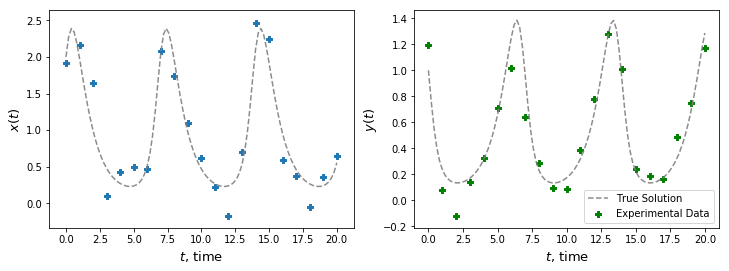

In [11]:
# Plotting our experimental data

f = plt.figure(figsize=(12,4))

ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.plot(solution['x'], alpha = 0.9, color = 'gray', linestyle ='--')
ax.scatter(t, sim_df["x"], marker = 'P')
ax.set_ylabel('$x(t)$', fontsize = 13)
ax.set_xlabel('$t$, time', fontsize = 13)

ax2.scatter(t, sim_df["y"], color = 'g', marker = 'P')
ax2.plot(solution['y'], alpha = 0.9, color = 'gray', linestyle ='--')
ax2.set_ylabel('$y(t)$', fontsize = 13)
ax2.set_xlabel('$t$, time', fontsize = 13)
ax2.legend(['True Solution', 'Experimental Data'], frameon = True)
plt.show()

In [12]:
#Prior

def prior(theta):
    return scipy.stats.norm.pdf(theta[0], 1.3, scale =3)*scipy.stats.norm.pdf(theta[1], 1.1, scale = 1.2)

In [30]:
a_grid = np.linspace(-3,4, 101)
b_grid = np.linspace(-2,4, 101)
prior_mat = np.zeros([len(a_grid),len(b_grid)])
for i in range(51):
    for j in range(51):
        prior_mat[len(a_grid) - j - 1, i] = prior([a_grid[j], b_grid[i]])

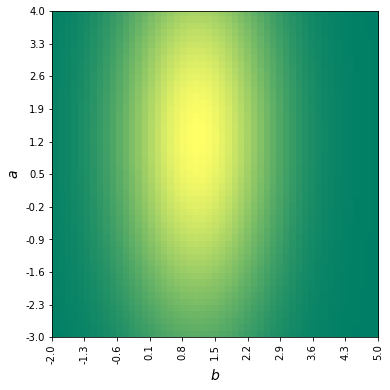

In [18]:
a_axis = []
for i in range(11):
    a_axis.append(np.round(a_grid[i*5], 2))
    
b_axis = []
for i in range(11):
    b_axis.append(np.round(b_grid[i*5],2))
    
a_axis.reverse()
    
fig = plt.figure(figsize = ([10,6]))
ax = fig.add_subplot(111)
ax.set_xticklabels(b_axis)
plt.xticks(range(len(b_axis)), rotation = 90)
ax.set_yticklabels(a_axis)
plt.yticks(range(len(a_axis)))
ax.xaxis.set_major_locator(plt.LinearLocator(11))
ax.yaxis.set_major_locator(plt.LinearLocator(11))
ax.set_xlabel('$b$', fontsize = 14)
ax.set_ylabel('$a$', fontsize = 14)

plt.imshow(prior_mat, cmap = cm.summer)

plt.savefig('comp_prior_heat.pdf', bbox_inches = 'tight')

In [36]:
import os

wd = os.getcwd()
print(wd)

C:\Users\thomas_armstrong


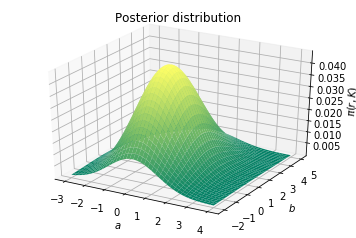

In [17]:
# Surface plot of the posterior density

x, y = np.meshgrid(a_grid, b_grid)
fig = plt.figure()

ax = fig.gca(projection='3d')
surf = ax.plot_surface(x, y, prior_mat, cmap=cm.summer,linewidth=0, antialiased=True)
ax.set_xlabel('$a$')
ax.set_ylabel('$b $')
ax.set_zlabel('$\pi(r, K)$')
ax.set_title("Posterior distribution")
plt.show()

In [19]:
def diff_eqn_soln(theta, initial_X, t):
    proposed_df = pd.DataFrame(index = t)
    output = integrate.odeint(dX_dt, initial_X, t, args = (theta,))
    proposed_df['x'] = output[:, 0]
    proposed_df['y'] = output[:, 1]
    return proposed_df


Sigma = np.array([[0.3, 0],
                  [0, 0.3]])


def log_norm_pdf(x, mean, sd):
    return -0.5*math.log(2*math.pi) - math.log(sd) -0.5*(1/(sd**2))*(x-mean)**2


def log_likelihood(theta, initial_X, t, sim_df, sd_1, sd_2):
    log_lik_sum = 0
    proposed_df = diff_eqn_soln(theta, initial_X, t)
    for index,obs in proposed_df.iterrows():
        log_lik_sum += log_norm_pdf(proposed_df.loc[index]['x'], sim_df.loc[index]['x'], sd_1) + log_norm_pdf(proposed_df.loc[index]['y'], sim_df.loc[index]['y'], sd_2) 
    return log_lik_sum


def posterior(theta, initial_X, t, sim_df,sd_1, sd_2):
    return prior(theta)*math.exp(log_likelihood(theta, initial_X, t, sim_df, sd_1, sd_2))

## Grid Inference 

In [31]:
un_normal_post = np.zeros((len(a_grid), len(b_grid)))
for i in range(len(a_grid)):
    for k in range(len(b_grid)):
        un_normal_post[len(b_grid) - 1 - k, i] = posterior([a_grid[k], b_grid[i]], initial_X, t, sim_df, sd_1, sd_2)

In [32]:
un_normal_post = np.nan_to_num(un_normal_post)
post_mat = un_normal_post / (un_normal_post.sum()*(a_grid[1] - a_grid[0])*(b_grid[1] - b_grid[0]))

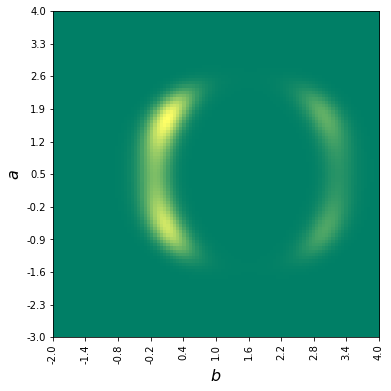

In [33]:
# Heatplot the grid of our posterior density

a_axis = []
for i in range(11):
    a_axis.append(np.round(a_grid[i*10], 2))
    
b_axis = []
for i in range(11):
    b_axis.append(np.round(b_grid[i*10],2))
    
a_axis.reverse()
    
fig = plt.figure(figsize = ([10,6]))
ax = fig.add_subplot(111)
ax.set_xticklabels(b_axis)
plt.xticks(range(len(b_axis)), rotation = 90)
ax.set_yticklabels(a_axis)
plt.yticks(range(len(a_axis)))
ax.xaxis.set_major_locator(plt.LinearLocator(11))
ax.yaxis.set_major_locator(plt.LinearLocator(11))
ax.set_xlabel('$b$', fontsize = 16)
ax.set_ylabel('$a$', fontsize = 16)

plt.imshow(post_mat, cmap = cm.summer)
plt.savefig('comp_grid_heat.pdf', bbox_inches = 'tight')

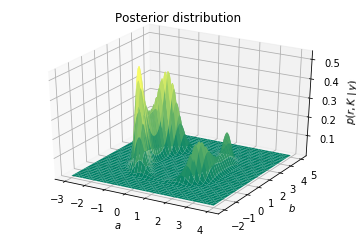

In [23]:
# Surface plot of the posterior density

x, y = np.meshgrid(a_grid, b_grid)
fig = plt.figure()

ax = fig.gca(projection='3d')
surf = ax.plot_surface(x, y, post_mat, cmap=cm.summer,linewidth=0, antialiased=True)
ax.set_xlabel('$a$')
ax.set_ylabel('$b $')
ax.set_zlabel('$p(r, K \mid y)$')
ax.set_title("Posterior distribution")
plt.show()

## MCMC inference

In [25]:
# Proposal distribution for the M-H algorithm

Delta = np.array([[0.2, 0],
                  [0, 0.5]])

def q_dist(mean, cov_mat):
    return scipy.stats.multivariate_normal.rvs(mean, cov_mat)    

In [26]:
# Convergence Diagnostic Tools

def test_for_cov_estimation(acceptance_log):
    # If the acceptance ratio falls below 0.15 or above 0.35, we will re-estimate the covaraiance matrix.
    ratio = sum(acceptance_log) / len(acceptance_log)
    if ratio < 0.15:
        return True, ratio
    elif ratio > 0.35:
        return True, ratio
    else: 
        return False, ratio
    
    
def estimate_var(samples):
    # Estimates the variance entry for one parameter
    samp_mean = np.mean(samples)
    var_estimate = 0
    for entry in samples:
        var_estimate = var_estimate + (entry - samp_mean)**2
    var_estimate = (1/(len(samples)-1))*var_estimate
    return var_estimate


def within(df_of_samples):
    """
    Calculates within-chain variance.
    """
    s = []
    for col in list(df_of_samples):
        s.append(np.var(df_of_samples[col]))
    W = np.mean(s)
    return W


def between(df_of_samples):
    """
    Calculates between-chain variance.
    """
    mu = []
    for col in list(df_of_samples):
        mu.append(np.mean(df_of_samples[col]))
    mu_overall = np.mean(mu)
    m = len(list(df_of_samples))
    n = len(df_of_samples[0])
    B = (n/(m- 1.0)) * np.sum((mu - mu_overall)**2)
    return B


def R_hat(samples):
    """
    Calculates r-hat = sqrt(((n - 1)/n * W + (1/n) * B)/W) as per "Bayesian
    data analysis", 3rd edition, Gelman et al., 2014.
    """
    W = within(samples)
    B = between(samples)
    n = len(samples[0])
    return np.sqrt((W + (1.0 / n) * (B - W)) / W)

In [27]:
def mh_algorithm(theta_0, n, m, q_dist):
    """
    Metropolis-Hastings algorithm, based on Information Theory, Inference, and
    Learning Algorithms, MacKay 2003.
    
    ------------------------------------------------------------------------
    
    Inputs
    
    theta_0 - set of starting starting for chains, must be length m
    n - duration to run the chain before checking R hat diagnostic
    m - number of chains
    q_dist - proposal distribution
    
    ------------------------------------------------------------------------
    
    Returns
    
    set_of_trace - dictionary of the m chains
    acceptance_hist - df of the history of proposed state acceptance
    ratio_hist - df of the acceptance ratio
    
    
    """
    iter_loop = 0
    acceptance_hist = []
    ratio_hist = []
    set_of_trace = {}
    C =  np.array([[0.1, 0], 
                   [0, 0.5]])
    for i in range(m):
        trace = pd.DataFrame(columns = ["r", "K"])
        trace = trace.append(pd.DataFrame([[theta_0[i][0],theta_0[i][1]]], columns = ["r", "K"]))
        loop_num = 1
        theta = theta_0[i]
        while loop_num < n:
            # Propose new step
            y = q_dist(theta, C)
            p_x = posterior(theta,  initial_X, t, sim_df,sd_1, sd_2)
            p_y = posterior(y, initial_X, t, sim_df,sd_1, sd_2)
            alpha = min(p_y / p_x, 1)
            # Generate random number to decide if we accept proposal
            rand = np.random.uniform(0,1)
            if rand > 1- alpha:
                theta_new = y
                acceptance_hist.append(1)
            else:
                theta_new = theta
                acceptance_hist.append(0)
            theta = theta_new
            
            trace = trace.append(pd.DataFrame([[theta[0],theta[1]]], columns = ["r", "K"]))

            # Every 100 iterations, re-calculate acceptance ratio
            if loop_num % 100 == 0:
                recal, ratio = test_for_cov_estimation(acceptance_hist)
                if recal:
                    C = np.array([[estimate_var(trace['r']),                        0], 
                                  [0                       , estimate_var(trace['K'])]])
                else: 
                    pass
                ratio_hist.append(ratio)
                
            loop_num = loop_num + 1
        trace = trace.reset_index()
        trace = trace.drop(["index"], axis=1)
        set_of_trace[i] = trace
    # Calculate and print R hat
    k_set_of_trace = {}
    r_set_of_trace = {}
    for i in range(len(set_of_trace)):
        k_set_of_trace[i] = set_of_trace[i]['K']
        r_set_of_trace[i] = set_of_trace[i]['r']
    r_hat_k = R_hat(k_set_of_trace)
    r_hat_r = R_hat(r_set_of_trace)
    print("----------------------------------")
    print("R hat statistic for r :" + str(r_hat_r))
    print("R hat statistic for K :" + str(r_hat_k))
    print("----------------------------------")
    return set_of_trace, pd.DataFrame(acceptance_hist), pd.DataFrame(ratio_hist)

In [31]:
theta_0 = []
for i in range(5):
    theta_0.append([stats.norm.rvs(loc = 1.3, scale = 3), stats.norm.rvs(loc = 1.1, scale = 1.2)])

In [32]:
theta_0

[[3.814565213078482, 1.1565004655967783],
 [-5.3635606569549248, 1.6385485365344863],
 [1.2596986694085912, 2.0444509709027132],
 [1.8650024183055134, -0.79627704915264541],
 [0.059344976072889688, -0.19163504769653961]]

In [33]:
set_of_trace, acceptance_hist, ratio_hist = mh_algorithm(theta_0, 10000, 5, q_dist)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in double_scalars


KeyboardInterrupt: 

In [ ]:
plt.plot(set_of_trace[0]['r'])
plt.plot(set_of_trace[1]['r'])
plt.plot(set_of_trace[2]['r'])
plt.plot(set_of_trace[3]['r'])
plt.plot(set_of_trace[4]['r'])
plt.title("Traceplot of all 5 chains for $r$")
plt.xlabel("# of iterations")
plt.ylabel("$r$")

plt.show()

In [ ]:
plt.plot(set_of_trace[0]['K'])
plt.plot(set_of_trace[1]['K'])
plt.plot(set_of_trace[2]['K'])
plt.plot(set_of_trace[3]['K'])
plt.plot(set_of_trace[4]['K'])
plt.title("Traceplot of all 5 chains for $K$")
plt.xlabel("# of iterations")
plt.ylabel("$K$")

plt.show()